# Building Better Features for Recession Prediction

Now that we've explored our data, it's time to get it ready for machine learning. We'll clean up missing values, create some lag variables (because economic indicators often predict the future), and normalize everything so our model doesn't get confused by different scales.

In [1]:
# Import notebook utilities
from notebook_utils import (
    # Setup functions
    setup_notebook, load_data, display_data_info, save_figure,
    
    # Import from econ_downturn package
    engineer_features, normalize_data, apply_pca
)

# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

# Set up the notebook environment
setup_notebook()

Notebook environment set up successfully.
Available data paths:
  fred_dir: /home/mattgroho/github/economic-downturn-detector/data/fred
  nber_dir: /home/mattgroho/github/economic-downturn-detector/data/nber
  processed_dir: /home/mattgroho/github/economic-downturn-detector/data/processed
  fred_all_indicators: /home/mattgroho/github/economic-downturn-detector/data/fred/all_indicators.csv
  nber_recession_indicator: /home/mattgroho/github/economic-downturn-detector/data/nber/recession_indicator.csv
  merged_data: /home/mattgroho/github/economic-downturn-detector/data/processed/merged_data.csv
  data_with_features: /home/mattgroho/github/economic-downturn-detector/data/processed/data_with_features.csv
  data_normalized: /home/mattgroho/github/economic-downturn-detector/data/processed/data_normalized.csv
  data_pca: /home/mattgroho/github/economic-downturn-detector/data/processed/data_pca.csv

Available output paths:
  images_dir: /home/mattgroho/github/economic-downturn-detector/docs/im

## Loading Our Clean Dataset

Let's grab the merged dataset we put together in our exploration phase.

In [2]:
# Load all data using the utility function
merged_data = load_data(use_cached=True)

# Display information about the dataset
display_data_info(merged_data)

Loading cached merged data from /home/mattgroho/github/economic-downturn-detector/data/processed/merged_data.csv
2025-06-09 17:54:31,375 - econ_downturn.data.data_loader - INFO - Loaded merged data with shape: (15657, 12)
Loaded merged data with shape: (15657, 12)
Dataset Information:
Time Range: 1970-01-01 00:00:00 to 2024-05-31 00:00:00
Number of Observations: 15657
Number of Features: 12

Summary Statistics:


,GDP,UNEMPLOYMENT,CPI,FED_FUNDS,YIELD_CURVE,INITIAL_CLAIMS,INDUSTRIAL_PROD,RETAIL_SALES,HOUSING_STARTS,CONSUMER_SENTIMENT,recession,SENTIMENT
count,218.000000,653.000000,653.000000,653.000000,11998.000000,2.839000e+03,653.000000,389.000000,653.000000,589.000000,653.000000,589.000000
mean,12837.776711,6.110260,158.663954,4.910490,0.868401,3.733381e+05,74.982246,365236.395887,1435.917305,84.583531,0.128637,84.583531
std,5217.489014,1.709394,73.783619,3.898737,0.925610,2.450608e+05,22.585732,138186.138422,410.165486,13.111529,0.335054,13.111529
min,5299.672000,3.400000,37.900000,0.050000,-2.410000,1.890000e+05,36.388100,158647.000000,478.000000,50.000000,0.000000,50.000000
25%,7760.008000,4.900000,100.100000,1.510000,0.190000,3.010000e+05,51.806000,264067.000000,1176.000000,74.300000,0.000000,74.300000
50%,12216.346500,5.800000,159.800000,5.050000,0.830000,3.460000e+05,78.919700,349869.000000,1465.000000,88.200000,0.000000,88.200000
75%,16937.626250,7.200000,219.035000,6.890000,1.500000,4.020000e+05,97.606000,443117.000000,1698.000000,94.200000,0.000000,94.200000
max,23223.906000,14.800000,313.140000,19.100000,2.910000,6.137000e+06,104.103800,691223.000000,2494.000000,112.000000,1.000000,112.000000



Missing Values:


,Missing Values,Percentage
GDP,15439,98.607652
RETAIL_SALES,15268,97.515488
CONSUMER_SENTIMENT,15068,96.238104
SENTIMENT,15068,96.238104
UNEMPLOYMENT,15004,95.829342
CPI,15004,95.829342
FED_FUNDS,15004,95.829342
INDUSTRIAL_PROD,15004,95.829342
HOUSING_STARTS,15004,95.829342
recession,15004,95.829342


## Creating Smart Features

Time to engineer some features that will help our model spot recession patterns. We'll create lag variables, moving averages, and other transformations that capture how economic indicators behave over time.

In [3]:
# Engineer features using the package function
data_with_features = engineer_features(merged_data)

print(f"Data shape after feature engineering: {data_with_features.shape}")
print(f"Number of features: {data_with_features.shape[1]}")

# Display the first few rows of the engineered data
display(data_with_features.head())

2025-06-09 17:54:31,406 - econ_downturn.features.feature_engineering - WARNING - There are still 15004 missing values after handling
2025-06-09 17:54:31,412 - econ_downturn.features.feature_engineering - INFO - Resampled data to M frequency, new shape: (653, 12)
2025-06-09 17:54:31,417 - econ_downturn.features.feature_engineering - INFO - Created lag variables with periods [1, 3, 6, 12], new shape: (653, 56)
2025-06-09 17:54:31,428 - econ_downturn.features.feature_engineering - INFO - Calculated rate of change with periods [1, 3, 12], new shape: (653, 89)
2025-06-09 17:54:31,429 - econ_downturn.features.feature_engineering - INFO - Dropped rows with missing values, new shape: (635, 89)
2025-06-09 17:54:31,429 - econ_downturn.features.feature_engineering - INFO - Completed feature engineering, final shape: (635, 89)
Data shape after feature engineering: (635, 89)
Number of features: 89


,GDP,UNEMPLOYMENT,CPI,FED_FUNDS,YIELD_CURVE,INITIAL_CLAIMS,INDUSTRIAL_PROD,RETAIL_SALES,HOUSING_STARTS,CONSUMER_SENTIMENT,SENTIMENT,GDP_lag1,GDP_lag3,GDP_lag6,GDP_lag12,UNEMPLOYMENT_lag1,UNEMPLOYMENT_lag3,UNEMPLOYMENT_lag6,UNEMPLOYMENT_lag12,CPI_lag1,CPI_lag3,CPI_lag6,CPI_lag12,FED_FUNDS_lag1,FED_FUNDS_lag3,FED_FUNDS_lag6,FED_FUNDS_lag12,YIELD_CURVE_lag1,YIELD_CURVE_lag3,YIELD_CURVE_lag6,YIELD_CURVE_lag12,INITIAL_CLAIMS_lag1,INITIAL_CLAIMS_lag3,INITIAL_CLAIMS_lag6,INITIAL_CLAIMS_lag12,INDUSTRIAL_PROD_lag1,INDUSTRIAL_PROD_lag3,INDUSTRIAL_PROD_lag6,INDUSTRIAL_PROD_lag12,RETAIL_SALES_lag1,RETAIL_SALES_lag3,RETAIL_SALES_lag6,RETAIL_SALES_lag12,HOUSING_STARTS_lag1,HOUSING_STARTS_lag3,HOUSING_STARTS_lag6,HOUSING_STARTS_lag12,CONSUMER_SENTIMENT_lag1,CONSUMER_SENTIMENT_lag3,CONSUMER_SENTIMENT_lag6,CONSUMER_SENTIMENT_lag12,SENTIMENT_lag1,SENTIMENT_lag3,SENTIMENT_lag6,SENTIMENT_lag12,GDP_pct_change_1,GDP_pct_change_3,GDP_pct_change_12,UNEMPLOYMENT_pct_change_1,UNEMPLOYMENT_pct_change_3,UNEMPLOYMENT_pct_change_12,CPI_pct_change_1,CPI_pct_change_3,CPI_pct_change_12,FED_FUNDS_pct_change_1,FED_FUNDS_pct_change_3,FED_FUNDS_pct_change_12,YIELD_CURVE_pct_change_1,YIELD_CURVE_pct_change_3,YIELD_CURVE_pct_change_12,INITIAL_CLAIMS_pct_change_1,INITIAL_CLAIMS_pct_change_3,INITIAL_CLAIMS_pct_change_12,INDUSTRIAL_PROD_pct_change_1,INDUSTRIAL_PROD_pct_change_3,INDUSTRIAL_PROD_pct_change_12,RETAIL_SALES_pct_change_1,RETAIL_SALES_pct_change_3,RETAIL_SALES_pct_change_12,HOUSING_STARTS_pct_change_1,HOUSING_STARTS_pct_change_3,HOUSING_STARTS_pct_change_12,CONSUMER_SENTIMENT_pct_change_1,CONSUMER_SENTIMENT_pct_change_3,CONSUMER_SENTIMENT_pct_change_12,SENTIMENT_pct_change_1,SENTIMENT_pct_change_3,SENTIMENT_pct_change_12,recession
1971-01-31,5443.619,5.9,39.9,4.14,0.68,292000.0,37.5101,159177.0,1828.0,72.4,72.4,5299.672,5299.672,5357.077,5300.652,6.1,5.5,5.0,3.9,39.8,39.4,38.9,37.9,4.90,6.20,7.21,8.98,0.68,0.68,0.68,0.68,321000.0,327000.0,287000.0,239000.0,37.2237,36.6098,37.6836,37.9288,159177.0,159177.0,159177.0,159177.0,1893.0,1580.0,1517.0,1085.0,72.4,77.6,75.4,78.1,72.4,77.6,75.4,78.1,0.027161,0.027161,0.026972,-0.032787,0.072727,0.512821,0.002513,0.012690,0.052770,-0.155102,-0.332258,-0.538976,0.0,0.0,0.0,-0.090343,-0.107034,0.221757,0.007694,0.024592,-0.011039,0.0,0.0,0.0,-0.034337,0.156962,0.684793,0.000000,-0.067010,-0.072983,0.000000,-0.067010,-0.072983,0.0
1971-02-28,5443.619,5.9,39.9,3.72,0.68,290000.0,37.4386,159177.0,1741.0,78.1,78.1,5443.619,5299.672,5357.077,5300.652,5.9,5.9,5.1,4.2,39.9,39.6,39.0,38.1,4.14,5.60,6.62,8.98,0.68,0.68,0.68,0.68,292000.0,337000.0,297000.0,242000.0,37.5101,36.3881,37.6164,37.9038,159177.0,159177.0,159177.0,159177.0,1828.0,1647.0,1399.0,1305.0,72.4,72.4,77.6,78.1,72.4,72.4,77.6,78.1,0.000000,0.027161,0.026972,0.000000,0.000000,0.404762,0.000000,0.007576,0.047244,-0.101449,-0.335714,-0.585746,0.0,0.0,0.0,-0.006849,-0.139466,0.198347,-0.001906,0.028869,-0.012273,0.0,0.0,0.0,-0.047593,0.057073,0.334100,0.078729,0.078729,0.000000,0.078729,0.078729,0.000000,0.0
1971-03-31,5443.619,6.0,40.0,3.71,0.68,300000.0,37.3980,159177.0,1910.0,78.1,78.1,5443.619,5299.672,5357.077,5300.652,5.9,6.1,5.4,4.4,39.9,39.8,39.2,38.3,3.72,4.90,6.29,7.76,0.68,0.68,0.68,0.68,290000.0,321000.0,333000.0,276000.0,37.4386,37.2237,37.3571,37.8546,159177.0,159177.0,159177.0,159177.0,1741.0,1893.0,1534.0,1319.0,78.1,72.4,77.6,78.1,78.1,72.4,77.6,78.1,0.000000,0.027161,0.026972,0.016949,-0.016393,0.363636,0.002506,0.005025,0.044386,-0.002688,-0.242857,-0.521907,0.0,0.0,0.0,0.034483,-0.065421,0.086957,-0.001084,0.004683,-0.012062,0.0,0.0,0.0,0.097071,0.008980,0.448067,0.000000,0.078729,0.000000,0.000000,0.078729,0.000000,0.0
1971-04-30,5473.059,5.9,40.1,4.16,0.68,288000.0,37.6080,159177.0,1986.0,78.1,78.1,5443.619,5443.619,5299.672,5308.164,6.0,5.9,5.5,4.6,40.0,39.9,39.4,38.5,3.71,4.14,6.20,8.10,0.68,0.68,0.68,0.68,300000.0,292000.0,327000.0,349000.0,37.3980,37.5101,36.6098,37.7573,159177.0,159177.0,159177.0,159177.0,1910.0,1828.0,1580.0,1264.0,78.1,7

## Getting Everything on the Same Scale

Different economic indicators have wildly different scales - unemployment might be 5% while GDP is in the trillions. Let's normalize everything so our model treats all features fairly.

In [4]:
# Normalize the data
data_normalized, scaler = normalize_data(data_with_features)

print(f"Data shape after normalization: {data_normalized.shape}")

# Display the first few rows of the normalized data
display(data_normalized.head())

2025-06-09 17:54:31,465 - econ_downturn.features.normalization - INFO - Normalized data using standard method, shape: (635, 89)
Data shape after normalization: (635, 89)


,GDP,UNEMPLOYMENT,CPI,FED_FUNDS,YIELD_CURVE,INITIAL_CLAIMS,INDUSTRIAL_PROD,RETAIL_SALES,HOUSING_STARTS,CONSUMER_SENTIMENT,SENTIMENT,GDP_lag1,GDP_lag3,GDP_lag6,GDP_lag12,UNEMPLOYMENT_lag1,UNEMPLOYMENT_lag3,UNEMPLOYMENT_lag6,UNEMPLOYMENT_lag12,CPI_lag1,CPI_lag3,CPI_lag6,CPI_lag12,FED_FUNDS_lag1,FED_FUNDS_lag3,FED_FUNDS_lag6,FED_FUNDS_lag12,YIELD_CURVE_lag1,YIELD_CURVE_lag3,YIELD_CURVE_lag6,YIELD_CURVE_lag12,INITIAL_CLAIMS_lag1,INITIAL_CLAIMS_lag3,INITIAL_CLAIMS_lag6,INITIAL_CLAIMS_lag12,INDUSTRIAL_PROD_lag1,INDUSTRIAL_PROD_lag3,INDUSTRIAL_PROD_lag6,INDUSTRIAL_PROD_lag12,RETAIL_SALES_lag1,RETAIL_SALES_lag3,RETAIL_SALES_lag6,RETAIL_SALES_lag12,HOUSING_STARTS_lag1,HOUSING_STARTS_lag3,HOUSING_STARTS_lag6,HOUSING_STARTS_lag12,CONSUMER_SENTIMENT_lag1,CONSUMER_SENTIMENT_lag3,CONSUMER_SENTIMENT_lag6,CONSUMER_SENTIMENT_lag12,SENTIMENT_lag1,SENTIMENT_lag3,SENTIMENT_lag6,SENTIMENT_lag12,GDP_pct_change_1,GDP_pct_change_3,GDP_pct_change_12,UNEMPLOYMENT_pct_change_1,UNEMPLOYMENT_pct_change_3,UNEMPLOYMENT_pct_change_12,CPI_pct_change_1,CPI_pct_change_3,CPI_pct_change_12,FED_FUNDS_pct_change_1,FED_FUNDS_pct_change_3,FED_FUNDS_pct_change_12,YIELD_CURVE_pct_change_1,YIELD_CURVE_pct_change_3,YIELD_CURVE_pct_change_12,INITIAL_CLAIMS_pct_change_1,INITIAL_CLAIMS_pct_change_3,INITIAL_CLAIMS_pct_change_12,INDUSTRIAL_PROD_pct_change_1,INDUSTRIAL_PROD_pct_change_3,INDUSTRIAL_PROD_pct_change_12,RETAIL_SALES_pct_change_1,RETAIL_SALES_pct_change_3,RETAIL_SALES_pct_change_12,HOUSING_STARTS_pct_change_1,HOUSING_STARTS_pct_change_3,HOUSING_STARTS_pct_change_12,CONSUMER_SENTIMENT_pct_change_1,CONSUMER_SENTIMENT_pct_change_3,CONSUMER_SENTIMENT_pct_change_12,SENTIMENT_pct_change_1,SENTIMENT_pct_change_3,SENTIMENT_pct_change_12,recession
1971-01-31,-1.461327,-0.140083,-1.664270,-0.185182,-0.199809,-0.304849,-1.717118,-0.848131,0.944882,-0.903522,-0.903522,-1.486073,-1.478791,-1.458195,-1.44965,-0.023535,-0.380060,-0.683463,-1.340000,-1.661903,-1.659973,-1.655766,-1.647170,0.008967,0.340239,0.596001,1.033978,-0.201645,-0.20497,-0.209752,-0.225602,-0.201553,-0.180790,-0.329633,-0.502389,-1.723420,-1.737373,-1.670647,-1.623891,-0.847087,-0.844908,-0.842085,-0.83752,1.099105,0.340965,0.190319,-0.848128,-0.904985,-0.503004,-0.669966,-0.474315,-0.904985,-0.503004,-0.669966,-0.474315,3.482761,1.919535,-0.045758,-0.351595,0.354379,1.737546,-0.214864,0.346434,0.431095,-1.154951,-0.760906,-0.261464,-0.051511,-0.022756,-0.031757,-0.122363,-0.146673,0.082112,0.631829,1.032037,-0.671179,-0.170688,-0.317636,-0.63707,-0.456526,1.386494,2.965761,-0.021041,-0.818392,-0.584002,-0.021041,-0.818392,-0.584002,0.0
1971-02-28,-1.461327,-0.140083,-1.664270,-0.292468,-0.199809,-0.311959,-1.720338,-0.848131,0.734989,-0.464391,-0.464391,-1.457972,-1.478791,-1.458195,-1.44965,-0.140749,-0.142873,-0.624656,-1.162766,-1.660523,-1.657206,-1.654377,-1.644371,-0.185082,0.187116,0.445637,1.033978,-0.201645,-0.20497,-0.209752,-0.225602,-0.305208,-0.144734,-0.294116,-0.491726,-1.710535,-1.747318,-1.673654,-1.625005,-0.847087,-0.844908,-0.842085,-0.83752,0.942459,0.502545,-0.094068,-0.318212,-0.904985,-0.903554,-0.500104,-0.474315,-0.904985,-0.903554,-0.500104,-0.474315,-0.328164,1.919535,-0.045758,-0.020520,-0.036258,1.356231,-0.970297,-0.256248,0.243669,-0.781927,-0.767625,-0.271137,-0.051511,-0.022756,-0.031757,-0.043565,-0.173933,0.064850,-0.365930,1.255782,-0.697500,-0.170688,-0.317636,-0.63707,-0.618576,0.478303,1.391286,1.488259,0.868733,-0.061194,1.488259,0.868733,-0.061194,0.0
1971-03-31,-1.461327,-0.081715,-1.662891,-0.295022,-0.199809,-0.276413,-1.722167,-0.848131,1.142713,-0.464391,-0.464391,-1.457972,-1.478791,-1.458195,-1.44965,-0.140749,-0.024279,-0.448233,-1.044610,-1.660523,-1.654438,-1.651598,-1.641571,-0.292319,0.008472,0.361535,0.724428,-0.201645,-0.20497,-0.209752,-0.225602,-0.312357,-0.202424,-0.166257,-0.370881,-1.713752,-1.709833,-1.685260,-1.627196,-0.847087,-0.844908,-0.842085,-0.83752,0.732796,1.095809,0.231290,-0.284490,-0.465974,-0.903554,-0.500104,-0.474315,-0.465974,-0.

## Reducing Complexity with PCA

With all these features, we might have too much of a good thing. PCA will help us find the most important patterns in our data while reducing complexity and dealing with correlated variables.

2025-06-09 17:54:31,495 - econ_downturn.features.normalization - INFO - Applied PCA retaining 95.0% of variance
2025-06-09 17:54:31,496 - econ_downturn.features.normalization - INFO - Number of PCA components: 24
2025-06-09 17:54:31,497 - econ_downturn.features.normalization - INFO - Cumulative explained variance: 0.9526
Data shape after PCA: (635, 24)
Number of PCA components: 23
Cumulative explained variance: 0.9526


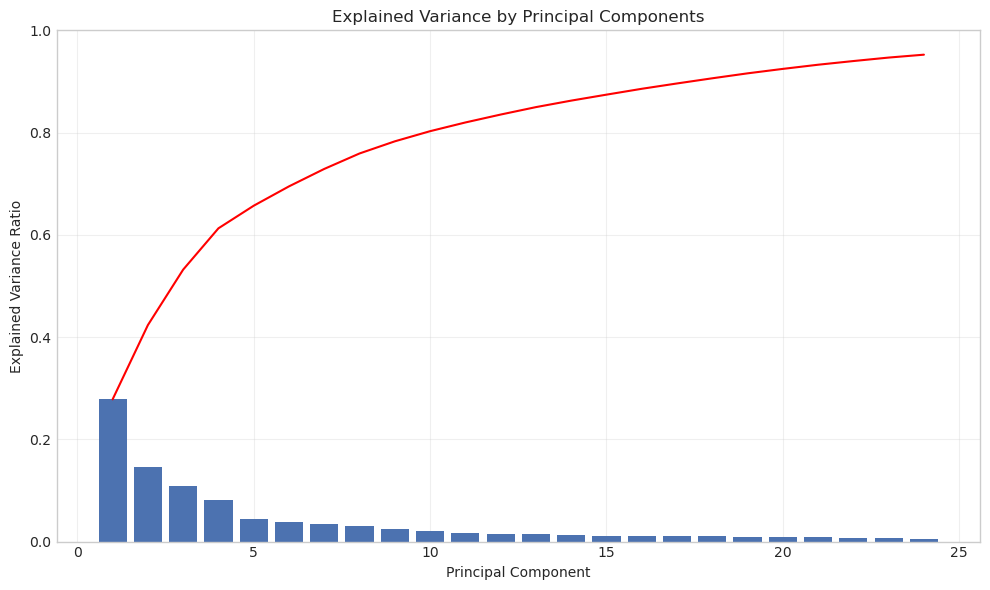

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/pca_explained_variance.png


<Figure size 1200x800 with 0 Axes>

In [5]:
# Separate features and target
X = data_normalized.drop(columns=['recession'])
y = data_normalized['recession']

# Apply PCA
X_pca_df, pca = apply_pca(X, n_components=0.95)

# Calculate explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)

print(f"Data shape after PCA: {X_pca_df.shape}")
print(f"Number of PCA components: {X_pca_df.shape[1] - 1}")  # Subtract 1 for target column
print(f"Cumulative explained variance: {explained_variance:.4f}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save the figure
save_figure(plt.gcf(), "pca_explained_variance.png")

## Saving Our Work

Time to save all these processed datasets so we can use them in our modeling phase.

In [6]:
# Get data paths for saving processed data
from econ_downturn import get_data_paths
data_paths = get_data_paths()
output_dir = data_paths['processed_dir']
os.makedirs(output_dir, exist_ok=True)

# Save the dataset with features
data_path = os.path.join(output_dir, 'data_with_features.csv')
data_with_features.to_csv(data_path)
print(f"Saved dataset with features to {data_path}")

# Save the normalized dataset
normalized_path = os.path.join(output_dir, 'data_normalized.csv')
data_normalized.to_csv(normalized_path)
print(f"Saved normalized dataset to {normalized_path}")

# Save the PCA dataset
pca_path = os.path.join(output_dir, 'data_pca.csv')
X_pca_df.to_csv(pca_path)
print(f"Saved PCA dataset to {pca_path}")

Saved dataset with features to /home/mattgroho/github/economic-downturn-detector/data/processed/data_with_features.csv
Saved normalized dataset to /home/mattgroho/github/economic-downturn-detector/data/processed/data_normalized.csv
Saved PCA dataset to /home/mattgroho/github/economic-downturn-detector/data/processed/data_pca.csv
